In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg
from brokenaxes import brokenaxes

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LIGHT_LASER = '#5E92EE'
LASER_COLOR = '#3375E9'#'#0033CC'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsin_control_animals = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19','AE_267','AO_273','AE_287']#,'AE_301']#,'AO_274' excluded due to slow post-reversal
# opsin_control_animals = ['AE_267','AO_273','AE_287']
# opsin_control_animals = ['AE_301']
#ephys_animals = opsin_control_animals
# opsin_control_animals = ['AE_267','AO_273','AE_287','AE_312']
opsin_control_animals = ['AE_267','AO_273','AE_287','AE_312']

#retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']

all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

current_version = 1 #July 18th 2023
current_version = 2 #August 3rd 2023
current_version = 3 #August 30th 2023
current_version = 4 #Sept 18th 2023
current_version = 5 #October 19th 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = animals = ['AE_368','AE_369','AE_389'  ,  'AE_363','AE_395']

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

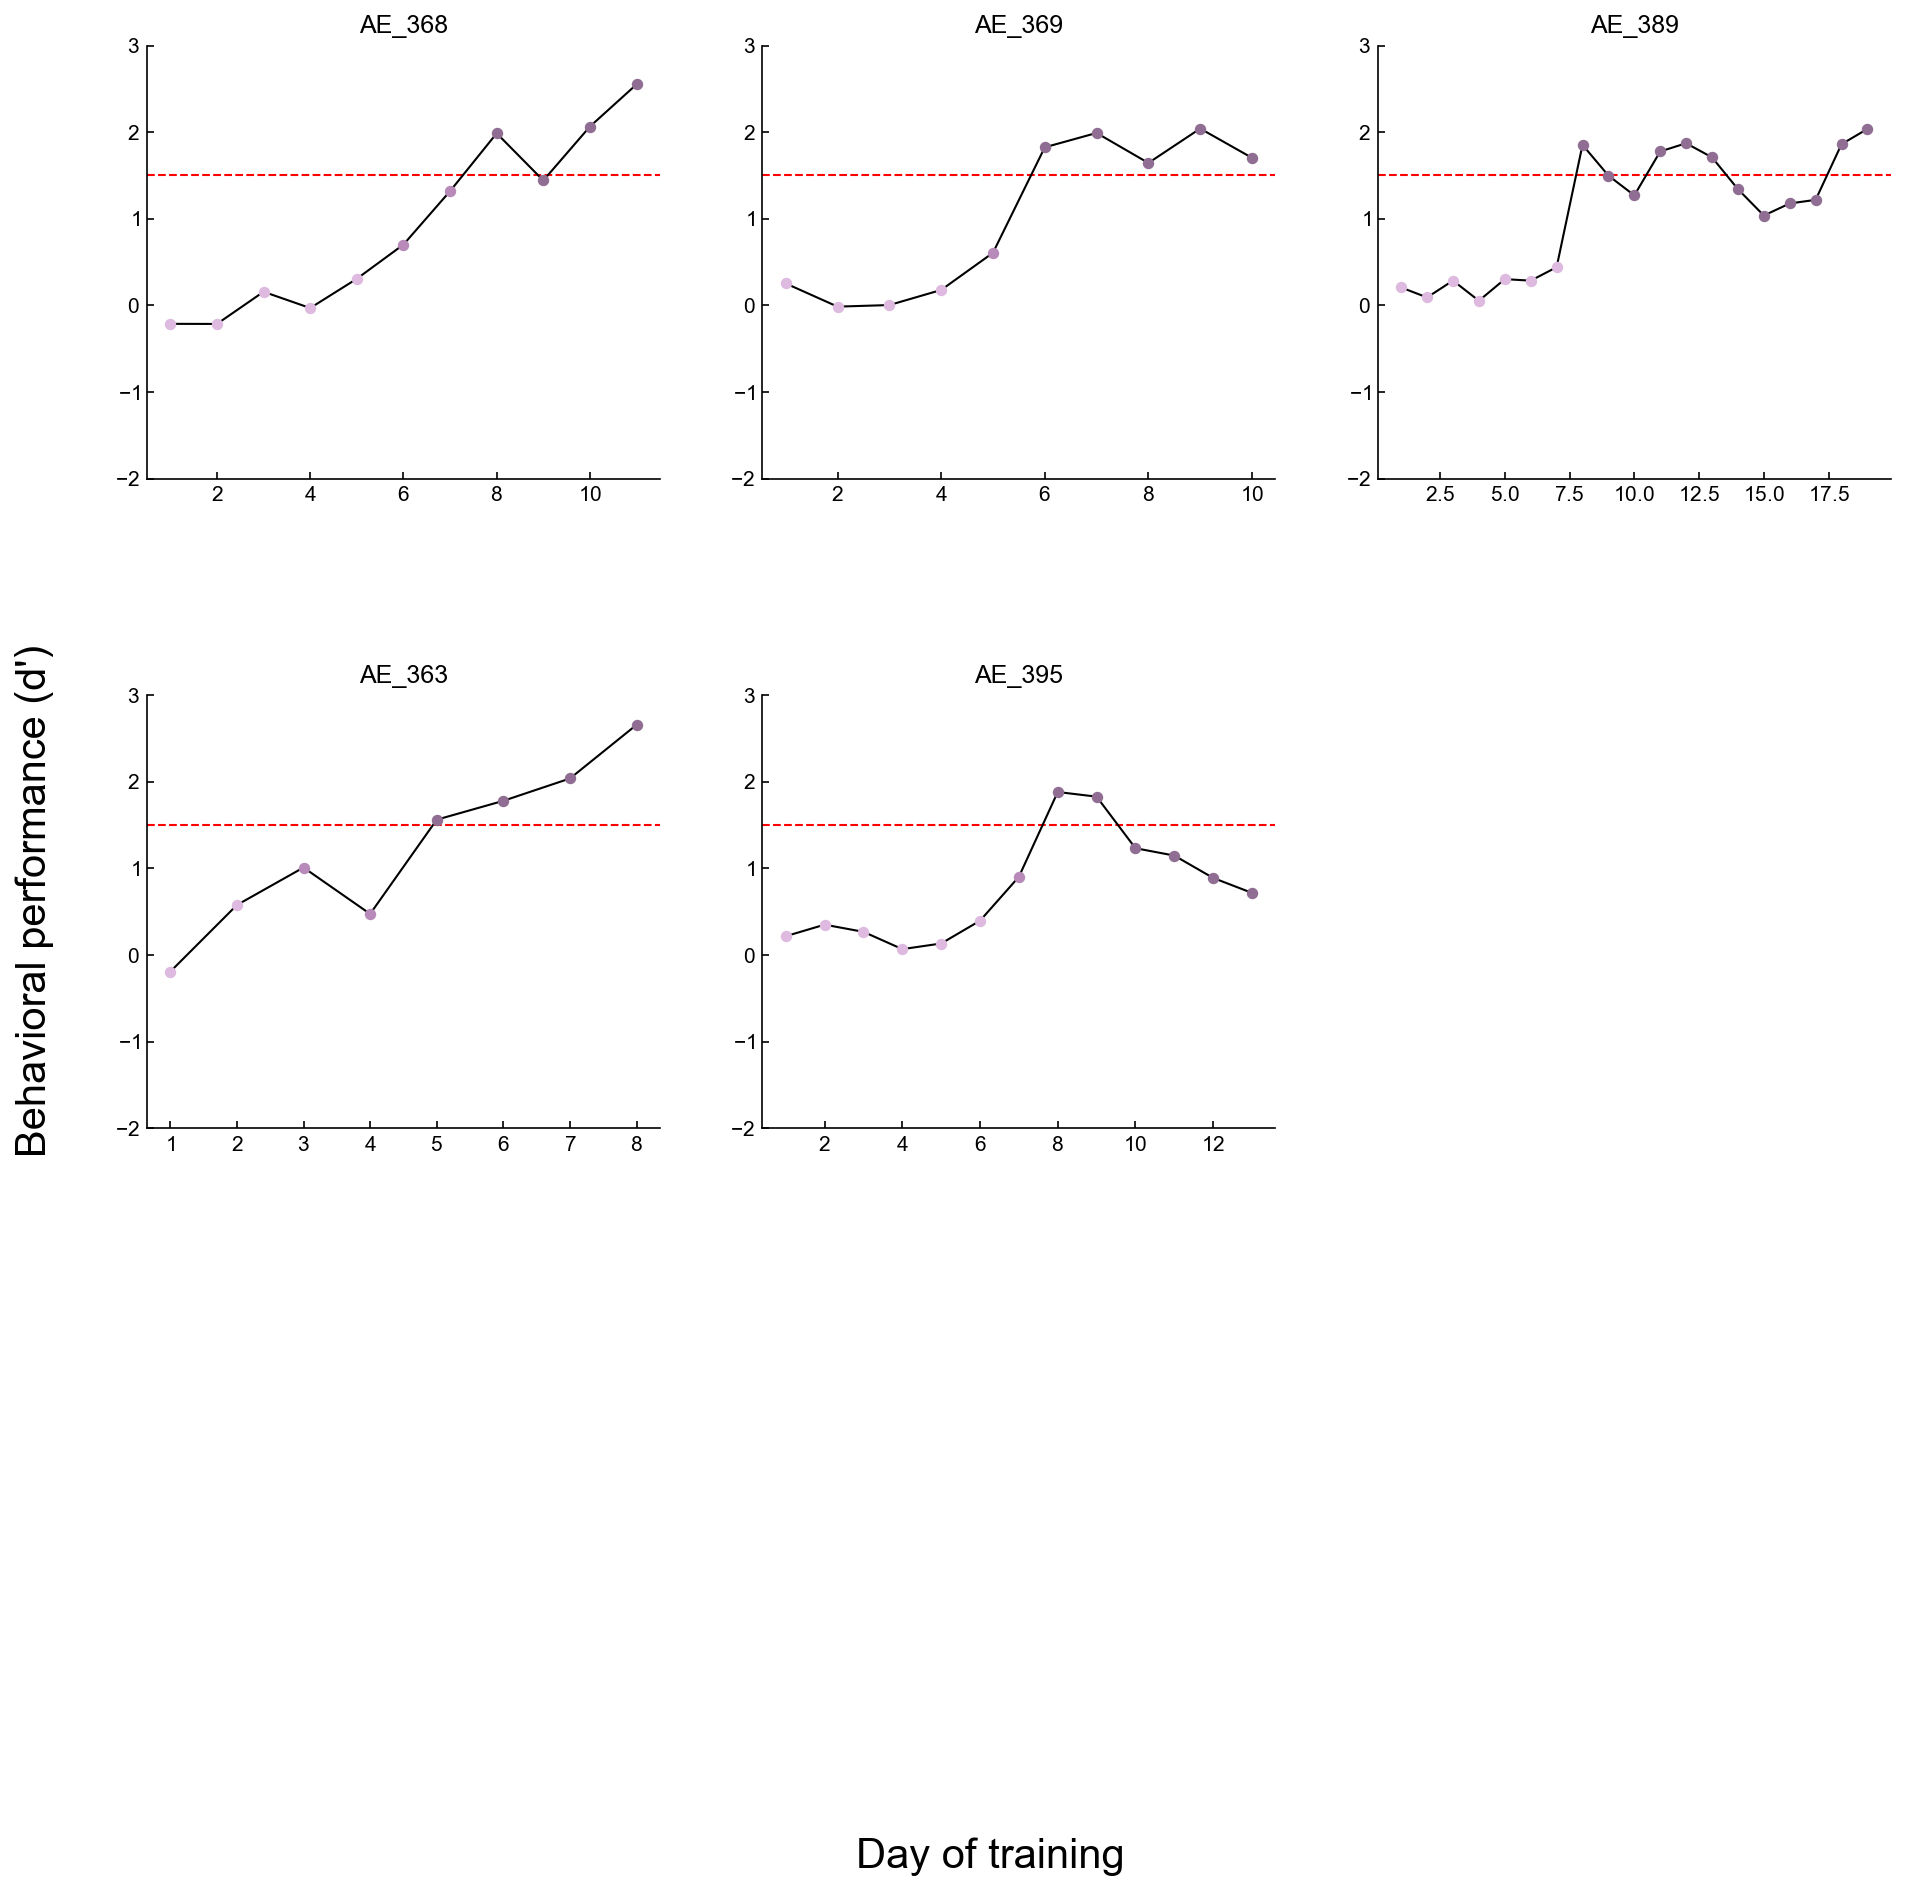

In [4]:
# learning_phases,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=False,noTrimPost=True)

learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True,noTrim=False)
# learning_phases2,_,_ = ilep.calculateLearningPhasesV2(did_not_learn_animals,animalBehaviors,plot=True,noTrim=True)
# learning_phases3,_,_ = ilep.calculateLearningPhasesV2(opsin_control_animals,animalBehaviors,plot=True,noTrim=False)
# for d in learning_phases2:
#     learning_phases[d] = learning_phases2[d]
# for d in learning_phases3:
#     learning_phases[d] = learning_phases3[d]

In [5]:
def get_outcomes(animal,day,noTrim=False):
    outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    valid_trials_mask = np.ones_like(outcomes,dtype='bool')
    
    if not noTrim:
        try:
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in learning_phases[animal].post_expert_days:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]
        except Exception as e:
            print(f"{animal} session {day}: {e}")
            return np.nan
    else:
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    return outcomes,valid_trials_mask

def get_response_times_internal(animal,day,noTrim=False):
    if not hasattr(animalBehaviors[animal].sessions[day],'response_time'):
        print('no response_time')
        return None,np.nan
    
    response_times = np.array(animalBehaviors[animal].sessions[day].response_time)
    outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    valid_trials_mask = np.ones_like(response_times,dtype='bool')
    
    if not noTrim:
        try:
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials_mask = exceptionTrials
                response_times = response_times[valid_trials_mask]
            elif day in learning_phases[animal].post_expert_days:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                response_times = response_times[valid_trials_mask]
        except Exception as e:
            print(f"{animal} session {day}: {e}")
            return None,np.nan
    else:
        response_times = np.array(animalBehaviors[animal].sessions[day].response_time)
    return response_times,valid_trials_mask
        
def get_dp(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    if not noTrim:
        dp,pc = ilep.getPCDPfromBehavior(animalBehaviors,animal,[day],learning_phases[animal].pre_expert_days,noTrim=noTrim)
        return dp[0]
    else:
        outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
        pc,dp = ilep.pcdpFromOutcomes(outcomes)
        return dp

def get_pc(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    if not noTrim:
        dp,pc = ilep.getPCDPfromBehavior(animalBehaviors,animal,[day],learning_phases[animal].pre_expert_days,noTrim=noTrim)
        return pc[0]*100
    else:
        outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
        pc,dp = ilep.pcdpFromOutcomes(outcomes)
        return pc*100
        
def get_hits(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
    hits = np.sum(np.equal(outcomes,1))
    misses = np.sum(np.equal(outcomes,2))
    return hits/(hits+misses)*100

def get_misses(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
    hits = np.sum(np.equal(outcomes,1))
    misses = np.sum(np.equal(outcomes,2))
    return misses/(hits+misses)*100

def get_falarms(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
    falarms = np.sum(np.equal(outcomes,3))
    crejects = np.sum(np.equal(outcomes,4))
    return falarms/(falarms+crejects)*100

def get_crejects(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
    falarms = np.sum(np.equal(outcomes,3))
    crejects = np.sum(np.equal(outcomes,4))
    return crejects/(falarms+crejects)*100

def get_go(animal,day,noTrim=False):
    if np.isnan(day):
        return np.nan
    
    outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
    hits = np.sum(np.equal(outcomes,1))
    misses = np.sum(np.equal(outcomes,2))
    falarms = np.sum(np.equal(outcomes,3))
    crejects = np.sum(np.equal(outcomes,4))
    return (hits+falarms)/(hits+misses+falarms+crejects)*100

# def get_response_times(animal,day,noTrim=False):
#     response_times,mask = get_response_times_internal(animal,day,noTrim=noTrim)
#     if response_times is None:
#         return np.nan
#     response_times = response_times[np.less(response_times,2.49)]
#     return np.mean(response_times)

# def get_response_times_target(animal,day,noTrim=False):
#     response_times,_ = get_response_times_internal(animal,day,noTrim=noTrim)
#     if response_times is None:
#         return np.nan
    
#     outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
#     target_mask = np.logical_or(np.equal(outcomes,1),np.equal(outcomes,2))
#     response_times = response_times[target_mask]
    
#     response_times = response_times[np.less(response_times,2.49)]
#     return np.mean(response_times)

# def get_response_times_nontarget(animal,day,noTrim=False):
#     response_times,_ = get_response_times_internal(animal,day,noTrim=noTrim)
#     if response_times is None:
#         return np.nan
    
#     outcomes,_ = get_outcomes(animal,day,noTrim=noTrim)
#     target_mask = np.logical_or(np.equal(outcomes,3),np.equal(outcomes,4))
#     response_times = response_times[target_mask]
    
#     response_times = response_times[np.less(response_times,2.49)]
#     return np.mean(response_times)

In [6]:
def get_response_times(animal,day,noTrim=False):#noTrim is deprecated
    NotFound = True
    for session in np.unique(EnumSession):
        sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
        if sessionfile.meta.animal == animal and sessionfile.meta.day_of_training == day:
            NotFound = False
            break
    if NotFound:
        print(f"{animal} day of training {day} not found")
        return np.nan
    else:
        print(f"{animal} day of training {day} found!")
        
    all_conds = ilep.getAllConditions(sessionfile,None)
    trials = all_conds['all_trials'].trials
    response_times = (sessionfile.trials.response[trials] - sessionfile.trials.starts[trials]) / sessionfile.meta.fs
    return np.mean(response_times)

def get_response_times_target(animal,day,noTrim=False):#noTrim is deprecated
    NotFound = True
    for session in np.unique(EnumSession):
        sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
        if sessionfile.meta.animal == animal and sessionfile.meta.day_of_training == day:
            NotFound = False
            break
    if NotFound:
        print(f"{animal} day of training {day} not found")
        return np.nan
        
    all_conds = ilep.getAllConditions(sessionfile,None)
    trials = all_conds['all_trials'].trials
    response_times = (sessionfile.trials.response[trials] - sessionfile.trials.starts[trials]) / sessionfile.meta.fs
    return np.mean(response_times)

def get_response_times_nontarget(animal,day,noTrim=False):#noTrim is deprecated
    NotFound = True
    for session in np.unique(EnumSession):
        sessionfile = ilep.loadSessionCached([act_directory,ops_directory],session)
        if sessionfile.meta.animal == animal and sessionfile.meta.day_of_training == day:
            NotFound = False
            break
    if NotFound:
        print(f"{animal} day of training {day} not found")
        return np.nan
        
    all_conds = ilep.getAllConditions(sessionfile,None)
    trials = all_conds['all_trials'].trials
    response_times = (sessionfile.trials.response[trials] - sessionfile.trials.starts[trials]) / sessionfile.meta.fs
    return np.mean(response_times)

In [7]:
animals_list = []
condition_list = []
avg_dp_list = []
    
for animal in ['AE_368','AE_369','AE_389']:
    animalBehaviors[animal].cloudiness = np.Inf #No cloudy window re: Abe
    
    ####################################################LATE##########################################################################
    test_day = np.nan
    try:
        max_day = np.max([k for k in animalBehaviors[animal].sessions])# - animalBehaviors[animal].reversal
        # if max_day > 10:
        #     max_day = 10
        
        if animalBehaviors[animal].cloudiness <= max_day:
            max_day = animalBehaviors[animal].cloudiness - 1
        
        if max_day < 6:
            continue
            
        test_day = max_day#animalBehaviors[animal].reversal + max_day
        days_to_calculate_animal = [test_day,test_day-1,test_day-2]
        
    except Exception as e:
        raise e
        pass    
    
    if animal == 'BS_100':                     #Do this for the paired analyses. BS_100 has no cutoff day data
        continue

    if animal == 'AE_389': #Must use the first laser sessions
        days_to_calculate_animal = [14,15,16]

    print(f"{animal}: {days_to_calculate_animal}")
    
    dp = (np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    
    animals_list.append(animal)
    avg_dp_list.append(dp)
    condition_list.append('opto')
    
    
print()
    
    
for animal in ['AE_363','AE_395','AE_389']:
    
    if animal in ['BS_50']:
        animals_list.append(animal)
        start_target_go_rate_list.append(np.nan)
        end_target_go_rate_list.append(np.nan)
        condition_list.append('control') #No post-reversal in this animal. Isn't included anyway in the control dataset though
        continue
        
    ####################################################LATE##########################################################################
        
    test_day = np.nan
    if len(learning_phases[animal].pre_expert_days) >= 3:
        days_to_calculate_animal = np.sort(learning_phases[animal].pre_expert_days)[0:3]
    else:
        try:
            max_day = np.max([k for k in animalBehaviors[animal].sessions])# - animalBehaviors[animal].reversal
            # if max_day > 10:
            #     max_day = 10
            test_day = max_day#animalBehaviors[animal].reversal + max_day
            days_to_calculate_animal = np.array([test_day,test_day-1,test_day-2])
            days_to_calculate_animal = days_to_calculate_animal[np.isin(days_to_calculate_animal,learning_phases[animal].pre_expert_days)]
            
            if max_day < 6:
                days_to_calculate_animal = [np.nan,np.nan,np.nan]
        except Exception as e:
            print(f"{animal}: {e}")
            pass

    if animal == 'AE_389': #Must use the pre-laser sessions
        days_to_calculate_animal = [13,12,11]
    if animal == 'AE_395': #Must use the laser sessions
        days_to_calculate_animal = [12,11,10]
    if animal == 'AE_363': #Must use the laser sessions
        days_to_calculate_animal = [8,7,6]
            
    print(f"{animal}: {days_to_calculate_animal}")

    dp = (np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    
    animals_list.append(animal)
    avg_dp_list.append(dp)
    condition_list.append('control')

AE_368: [11, 10, 9]
AE_369: [10, 9, 8]
AE_389: [14, 15, 16]

AE_363: [8, 7, 6]
AE_395: [12, 11, 10]
AE_389: [13, 12, 11]


In [8]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['d\''] = avg_dp_list
df_dict['condition'] = condition_list
df = pd.DataFrame(df_dict)

In [9]:
df

,animal,d',condition
0,AE_368,2.019125,opto
1,AE_369,1.796091,opto
2,AE_389,1.185142,opto
3,AE_363,2.158951,control
4,AE_395,1.090758,control
5,AE_389,1.785744,control


In [10]:
opto_dps = []
control_dps = []

for row in df.iloc:
    if row['condition'] == 'opto':
        opto_dps.append(row['d\''])
    if row['condition'] == 'control':
        control_dps.append(row['d\''])

In [11]:
opto_dps

[2.0191250829140333, 1.7960912299203298, 1.1851424296296709]

In [12]:
control_dps

[2.158951383760865, 1.0907580881698318, 1.7857441736629138]

In [13]:
control_dps = []
control_pcs = []
control_hits = []
control_misses = []
control_falarms = []
control_crejects = []
control_go = []
control_response_times = []
control_response_times_target = []
control_response_times_nontarget = []

opsin_dps = []
opsin_pcs = []
opsin_hits = []
opsin_misses = []
opsin_falarms = []
opsin_crejects = []
opsin_go = []
opsin_response_times = []
opsin_response_times_target = []
opsin_response_times_nontarget = []

days_to_calculate = [0,1,2]

for animal in opsin_control_animals:
    print(animal)
    
    this_animal_dps = []
    this_animal_pcs = []
    this_animal_hits = []
    this_animal_misses = []
    this_animal_falarms = []
    this_animal_crejects = []
    this_animal_go = []
    this_animal_rxn = []
    this_animal_rxn_target = []
    this_animal_rxn_nontarget = []
    
    if animal in ['BS_50']:
        control_dps.append(np.nan)
        control_pcs.append(np.nan)
        control_hits.append(np.nan)
        control_misses.append(np.nan)
        control_falarms.append(np.nan)
        control_crejects.append(np.nan)
        control_go.append(np.nan)
        control_response_times.append(np.nan)
        control_response_times_target.append(np.nan)
        control_response_times_nontarget.append(np.nan)
        continue
        
    test_day = np.nan
    if len(learning_phases[animal].post_expert_days) >= 3:
        days_to_calculate_animal = np.sort(learning_phases[animal].post_expert_days)[0:3]
    else:
        try:
            max_day = np.max([k for k in animalBehaviors[animal].sessions]) - animalBehaviors[animal].reversal
            if max_day > 12:
                max_day = 12
            test_day = animalBehaviors[animal].reversal + max_day
            days_to_calculate_animal = np.array([test_day,test_day-1,test_day-2])
            days_to_calculate_animal = days_to_calculate_animal[np.isin(days_to_calculate_animal,learning_phases[animal].post_expert_days)]
            # if animal == 'AO_273':
            #     days_to_calculate_animal = [test_day,test_day-1]
            
            if max_day < 6:
                days_to_calculate_animal = [np.nan,np.nan,np.nan]
        except Exception as e:
            print(f"{animal}: {e}")
            pass
    print(f"{animal}: {days_to_calculate_animal}")
#     print(animal)
    control_dps.append(np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_pcs.append(np.mean([get_pc(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_hits.append(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_misses.append(np.mean([get_misses(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_falarms.append(np.mean([get_falarms(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_crejects.append(np.mean([get_crejects(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    control_go.append(np.mean([get_go(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     if animal not in ['DS_15','DS_19']: #Animals excluded because this is reconstructed data which does not include response times
#         control_response_times.append(np.mean([get_response_times(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#         control_response_times_target.append(np.mean([get_response_times_target(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#         control_response_times_nontarget.append(np.mean([get_response_times_nontarget(animal,x,noTrim=False) for x in days_to_calculate_animal]))
# control_dps = ilep.rmnan(control_dps)
# control_pcs = ilep.rmnan(control_pcs)
# control_hits = ilep.rmnan(control_hits)
# control_misses = ilep.rmnan(control_misses)
# control_falarms = ilep.rmnan(control_falarms)
# control_crejects = ilep.rmnan(control_crejects)
# control_response_times = ilep.rmnan(control_response_times)
# control_response_times_target = ilep.rmnan(control_response_times_target)
# control_response_times_nontarget = ilep.rmnan(control_response_times_nontarget)

for animal in did_not_learn_animals:
    test_day = np.nan
    try:
        max_day = np.max([k for k in animalBehaviors[animal].sessions]) - animalBehaviors[animal].reversal
        if max_day > 12:
            max_day = 12
        
        if animalBehaviors[animal].cloudiness <= max_day:
            max_day = animalBehaviors[animal].cloudiness - 1
            
        if max_day < 6:
            continue
            
        test_day = animalBehaviors[animal].reversal + max_day
        days_to_calculate_animal = [test_day,test_day-1,test_day-2]
        
    except Exception as e:
        raise e
        pass
    
    if animal == 'BS_100':                     #Do this for the paired analyses. BS_100 has no cutoff day data
        continue
    
    print(animal)
#     print(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    
    opsin_dps.append(np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_pcs.append(np.mean([get_pc(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_hits.append(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_misses.append(np.mean([get_misses(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_falarms.append(np.mean([get_falarms(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_crejects.append(np.mean([get_crejects(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    opsin_go.append(np.mean([get_go(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     opsin_response_times.append(np.mean([get_response_times(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     opsin_response_times_target.append(np.mean([get_response_times_target(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     opsin_response_times_nontarget.append(np.mean([get_response_times_nontarget(animal,x,noTrim=False) for x in days_to_calculate_animal]))
# opsin_dps = ilep.rmnan(opsin_dps)
# opsin_pcs = ilep.rmnan(opsin_pcs)
# opsin_hits = ilep.rmnan(opsin_hits)
# opsin_misses = ilep.rmnan(opsin_misses)
# opsin_falarms = ilep.rmnan(opsin_falarms)
# opsin_crejects = ilep.rmnan(opsin_crejects)
# opsin_response_times = ilep.rmnan(opsin_response_times)
# opsin_response_times_target = ilep.rmnan(opsin_response_times_target)
# opsin_response_times_nontarget = ilep.rmnan(opsin_response_times_nontarget)

AE_267
AE_267: [14 15 16]
AO_273
AO_273: [18]
AE_287
AE_287: [16 17 18]
AE_312
AE_312: [10 11 12]
BS_86
BS_119
BS_123
BS_128
BS_131
BS_163
BS_174


In [14]:
early_control_dps = []
early_control_pcs = []
early_control_hits = []
early_control_misses = []
early_control_falarms = []
early_control_crejects = []
early_control_go = []
early_control_response_times = []
early_control_response_times_target = []
early_control_response_times_nontarget = []

early_opsin_dps = []
early_opsin_pcs = []
early_opsin_hits = []
early_opsin_misses = []
early_opsin_falarms = []
early_opsin_crejects = []
early_opsin_go = []
early_opsin_response_times = []
early_opsin_response_times_target = []
early_opsin_response_times_nontarget = []

days_to_calculate = [0,1,2]

for animal in opsin_control_animals:
    
    this_animal_dps = []
    this_animal_pcs = []
    this_animal_hits = []
    this_animal_misses = []
    this_animal_falarms = []
    this_animal_crejects = []
    this_animal_go = []
    this_animal_rxn = []
    this_animal_rxn_target = []
    this_animal_rxn_nontarget = []
    
    if animal == 'BS_50':
        early_control_dps.append(np.nan)
        early_control_pcs.append(np.nan)
        early_control_hits.append(np.nan)
        early_control_misses.append(np.nan)
        early_control_falarms.append(np.nan)
        early_control_crejects.append(np.nan)
        early_control_go.append(np.nan)
        early_control_response_times.append(np.nan)
        early_control_response_times_target.append(np.nan)
        early_control_response_times_nontarget.append(np.nan)
        continue
        
    if len(learning_phases[animal].post_early_days) >= 3:
        days_to_calculate_animal = np.sort(learning_phases[animal].post_early_days)[0:3]
    else:
        days_to_calculate_animal = [animalBehaviors[animal].reversal+1,animalBehaviors[animal].reversal+2,animalBehaviors[animal].reversal+3]
    
#     print(animal)
    print(f"{animal}: {days_to_calculate_animal}")
    
    early_control_dps.append(np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_pcs.append(np.mean([get_pc(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_hits.append(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_misses.append(np.mean([get_misses(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_falarms.append(np.mean([get_falarms(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_crejects.append(np.mean([get_crejects(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_control_go.append(np.mean([get_go(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     if animal not in ['DS_15','DS_19']: #Animals excluded because this is reconstructed data which does not include response times
#         early_control_response_times.append(np.mean([get_response_times(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#         early_control_response_times_target.append(np.mean([get_response_times_target(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#         early_control_response_times_nontarget.append(np.mean([get_response_times_nontarget(animal,x,noTrim=False) for x in days_to_calculate_animal]))
# early_control_dps = ilep.rmnan(early_control_dps)
# early_control_pcs = ilep.rmnan(early_control_pcs)
# early_control_hits = ilep.rmnan(early_control_hits)
# early_control_misses = ilep.rmnan(early_control_misses)
# early_control_falarms = ilep.rmnan(early_control_falarms)
# early_control_crejects = ilep.rmnan(early_control_crejects)
# early_control_response_times = ilep.rmnan(early_control_response_times)
# early_control_response_times_target = ilep.rmnan(early_control_response_times_target)
# early_control_response_times_nontarget = ilep.rmnan(early_control_response_times_nontarget)

for animal in did_not_learn_animals:
    days_to_calculate_animal = [animalBehaviors[animal].reversal+1,animalBehaviors[animal].reversal+2,animalBehaviors[animal].reversal+3]
    
    if animal == 'BS_100':                     #Do this for the paired analyses. BS_100 has no cutoff day data
        continue
    
    print(animal)
#     print(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    
    early_opsin_dps.append(np.mean([get_dp(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_pcs.append(np.mean([get_pc(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_hits.append(np.mean([get_hits(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_misses.append(np.mean([get_misses(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_falarms.append(np.mean([get_falarms(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_crejects.append(np.mean([get_crejects(animal,x,noTrim=False) for x in days_to_calculate_animal]))
    early_opsin_go.append(np.mean([get_go(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     early_opsin_response_times.append(np.mean([get_response_times(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     early_opsin_response_times_target.append(np.mean([get_response_times_target(animal,x,noTrim=False) for x in days_to_calculate_animal]))
#     early_opsin_response_times_nontarget.append(np.mean([get_response_times_nontarget(animal,x,noTrim=False) for x in days_to_calculate_animal]))
# early_opsin_dps = ilep.rmnan(early_opsin_dps)
# early_opsin_pcs = ilep.rmnan(early_opsin_pcs)
# early_opsin_hits = ilep.rmnan(early_opsin_hits)
# early_opsin_misses = ilep.rmnan(early_opsin_misses)
# early_opsin_falarms = ilep.rmnan(early_opsin_falarms)
# early_opsin_crejects = ilep.rmnan(early_opsin_crejects)
# early_opsin_response_times = ilep.rmnan(early_opsin_response_times)
# early_opsin_response_times_target = ilep.rmnan(early_opsin_response_times_target)
# early_opsin_response_times_nontarget = ilep.rmnan(early_opsin_response_times_nontarget)

AE_267: [ 8  9 10]
AO_273: [7 8 9]
AE_287: [10, 11, 12]
AE_312: [6 7 8]
BS_86
BS_119
BS_123
BS_128
BS_131
BS_163
BS_174


Opto d' = 1.6667862474880113 +/- 0.35253519952497686
Control d' = 1.6784845485312034 +/- 0.44263431074567966
3 opto animals
3 control animals
ttest_ind
sig: False
pval: 0.4890383264625142


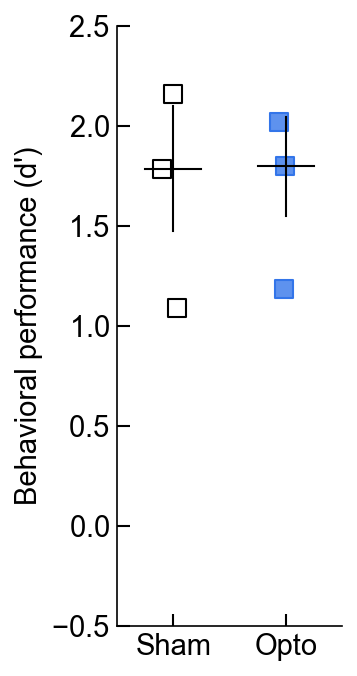

In [14]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(1.5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
meanwidth = 0.25

################################################################################################################
sz = 75

X,Y = ilep.violin(np.ones_like(opto_dps),opto_dps,width=0.5)
ax.scatter(X,Y,fc=LIGHT_LASER,ec=LASER_COLOR,s=sz,marker='s')
ax.plot([1-meanwidth,1+meanwidth],[np.median(opto_dps)]*2,lw=1,color='k')
data_sem = sem(Y)
ax.plot([1,1],[np.median(opto_dps)-data_sem,np.median(opto_dps)+data_sem],lw=1,color='k')

X,Y = ilep.violin(np.zeros_like(control_dps),control_dps,width=0.5)
#X = 0
#Y = control_dps
ax.scatter(X,Y,ec='k',fc='white',s=sz,marker='s')
# ax.scatter(X[len(X)-2:len(X)],Y[len(Y)-2:len(Y)],color='purple',s=20,marker='s')
ax.plot([0-meanwidth,0+meanwidth],[np.median(control_dps)]*2,lw=1,color='k')
data_sem = sem(Y)
ax.plot([0,0],[np.median(control_dps)-data_sem,np.median(control_dps)+data_sem],lw=1,color='k')

################################################################################################################

labels = ['Control','Opto']

ax.set_ylim([-0.5,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim(-0.5,1.5)
ax.set_xticks([0,1])
ax.set_xticklabels(['Sham','Opto'])
# colors = [GOOD_GREY,LASER_COLOR]
# [t.set_color(colors[idx]) for idx,t in enumerate(ax.xaxis.get_ticklabels())]

# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
# t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
# t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
# ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
# for item in (ax.get_xticklabels()):
#     item.set_fontsize(stdfont*0.9)
#     pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

print(f"Opto d' = {np.nanmean(opto_dps)} +/- {np.nanstd(opto_dps)}")
print(f"Control d' = {np.nanmean(control_dps)} +/- {np.nanstd(control_dps)}")
print(f"{len(ilep.rmnan(opto_dps))} opto animals")
print(f"{len(ilep.rmnan(control_dps))} control animals")
print('ttest_ind')
test = ttest_ind(ilep.rmnan(opto_dps),ilep.rmnan(control_dps),alternative='less')
pval = test.pvalue
sig = np.abs(pval) < 0.05
print('sig: '+str(sig))
print('pval: '+str(pval))

artists = [ylab]
fig.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\Pre opsin steady state dp at cutoff.pdf V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')